In [1]:
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import Flatten, Conv2D, MaxPooling2D
from keras.losses import sparse_categorical_crossentropy, mse
from keras.optimizers import Adam
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
num_classes = 10
batch_size = 100
epochs = 10
stats = []

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
# input image dimensions
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

('x_train shape:', (60000, 28, 28, 1))
(60000, 'train samples')
(10000, 'test samples')


In [6]:
x = Input(shape=input_shape)
h = Conv2D(32, (3, 3), activation='relu')(x)
h = Conv2D(64, (3, 3), activation='relu')(h)
h = MaxPooling2D(pool_size=(2, 2))(h)
h = Dropout(0.25)(h)
h = Flatten()(h)
h = Dense(128, activation='relu')(h)
h = Dropout(0.5)(h)
p = Dense(num_classes, activation='softmax')(h)
h = Dense(128, activation='relu')(h)
b = Dense(1)(h)
a = Input(shape=(1,))
model = Model([x, a], [p, b])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 26, 26, 32)    320         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 24, 24, 64)    18496       conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 12, 12, 64)    0           conv2d_2[0][0]                   
___________________________________________________________________________________________

In [7]:
def policy_gradient_loss(y_true, y_pred):
    return a * sparse_categorical_crossentropy(y_true, y_pred)[:, np.newaxis]

model.compile(loss=[policy_gradient_loss, mse],
              optimizer=Adam(lr=0.0005))

In [8]:
for n in range(epochs):
    for i in range(0, x_train.shape[0], batch_size):
        x_batch = x_train[i:(i + batch_size)]
        y_batch = y_train[i:(i + batch_size)]

        # predict class probabilities
        a = np.zeros((x_batch.shape[0], 1))
        y_preds, baselines = model.predict([x_batch, a])

        # sample from those probabilities
        y_sample = np.empty((batch_size,), dtype=np.integer)
        for j, p in enumerate(y_preds):
            y_sample[j] = np.random.choice(num_classes, p=p)

        # calculate accuracy for logging
        y_preds = np.argmax(y_preds, axis=1)
        accuracy = np.mean(y_preds == y_batch)
        baseline = np.mean(baselines)

        # calculate reward and advantage, update baseline
        rewards = (y_sample == y_batch)[:, np.newaxis]
        advantages = rewards - baselines

        # train with samples as targets and advantage as sample weight
        losses = model.train_on_batch([x_batch, advantages], [y_sample, rewards])

        # log statistics
        stats.append(losses + [accuracy, baseline])
        print(i, losses, accuracy, baseline)

(0, [0.42733741, 0.29970565, 0.12763174], 0.050000000000000003, 0.0026825592)
(100, [0.032875378, -0.058473978, 0.091349356], 0.17000000000000001, 0.11423631)
(200, [0.019986145, -0.063918255, 0.0839044], 0.17999999999999999, 0.10783045)
(300, [0.12405509, 0.047002655, 0.077052429], 0.20999999999999999, 0.059133139)
(400, [0.24540037, 0.16941048, 0.075989895], 0.23000000000000001, 0.0052597211)
(500, [0.31277981, 0.21177357, 0.10100623], 0.23000000000000001, -0.0029053551)
(600, [0.27698967, 0.1852338, 0.091755867], 0.17999999999999999, 0.009356264)
(700, [0.20560515, 0.12018037, 0.085424788], 0.20999999999999999, 0.028400099)
(800, [0.18194684, 0.094655126, 0.087291718], 0.19, 0.05362501)
(900, [0.10708795, 0.019709475, 0.087378472], 0.28000000000000003, 0.078460269)
(1000, [0.053152338, -0.025915632, 0.079067968], 0.26000000000000001, 0.087209336)
(1100, [0.12886021, 0.036685303, 0.09217491], 0.20000000000000001, 0.078885846)
(1200, [0.11358901, 0.027971253, 0.085617758], 0.200000000

(11000, [0.39191863, 0.13238972, 0.25952891], 0.85999999999999999, 0.29990229)
(11100, [0.25617722, 0.037039392, 0.21913782], 0.80000000000000004, 0.29037088)
(11200, [0.17428675, -0.035780124, 0.21006688], 0.75, 0.32996318)
(11300, [0.29778111, 0.082539536, 0.21524158], 0.76000000000000001, 0.3261613)
(11400, [0.29886341, 0.084486693, 0.21437673], 0.80000000000000004, 0.32355514)
(11500, [0.27261674, 0.0019950948, 0.27062166], 0.70999999999999996, 0.35795677)
(11600, [0.36392739, 0.10693979, 0.2569876], 0.70999999999999996, 0.33774623)
(11700, [0.1816518, -0.073649906, 0.25530171], 0.70999999999999996, 0.34668115)
(11800, [0.21337977, 0.011615272, 0.20176449], 0.71999999999999997, 0.33857468)
(11900, [0.18296328, -0.0007707745, 0.18373406], 0.68999999999999995, 0.32102445)
(12000, [0.28942516, 0.00512848, 0.28429669], 0.83999999999999997, 0.33206981)
(12100, [0.24480635, 0.019006224, 0.22580013], 0.81999999999999995, 0.37069243)
(12200, [0.33208919, 0.096126594, 0.23596258], 0.7700000

(21500, [0.18483642, 0.012004383, 0.17283203], 0.89000000000000001, 0.38612294)
(21600, [0.19322634, 0.028854765, 0.16437158], 0.92000000000000004, 0.39507699)
(21700, [0.18848632, 0.039465416, 0.14902091], 0.95999999999999996, 0.40815669)
(21800, [0.21716878, 0.038933299, 0.17823549], 0.95999999999999996, 0.40857142)
(21900, [0.25380272, 0.091346331, 0.16245639], 0.93999999999999995, 0.43493024)
(22000, [0.1543196, -0.0020009282, 0.15632053], 0.93999999999999995, 0.43719846)
(22100, [0.2521672, 0.046682183, 0.20548502], 0.85999999999999999, 0.42834204)
(22200, [0.17042688, -0.02262464, 0.19305152], 0.89000000000000001, 0.43767044)
(22300, [0.22453013, 0.089458138, 0.13507199], 0.97999999999999998, 0.48061585)
(22400, [0.13750702, -0.05481058, 0.19231761], 0.89000000000000001, 0.4732765)
(22500, [0.28930327, -0.013093395, 0.30239666], 0.81999999999999995, 0.42890531)
(22600, [0.23594861, 0.028430436, 0.20751818], 0.90000000000000002, 0.47228912)
(22700, [0.10495287, -0.10250126, 0.2074

(32000, [0.1549978, 0.062679432, 0.092318356], 0.91000000000000003, 0.54259473)
(32100, [0.11016788, 0.0046253847, 0.1055425], 0.94999999999999996, 0.5127371)
(32200, [0.097379364, -0.039196305, 0.13657567], 0.94999999999999996, 0.51065695)
(32300, [0.1176817, -0.054699972, 0.17238167], 0.90000000000000002, 0.47561622)
(32400, [0.12978752, -0.026848862, 0.15663639], 0.91000000000000003, 0.48380554)
(32500, [0.069260992, -0.011379267, 0.080640256], 0.95999999999999996, 0.50773752)
(32600, [0.12454692, 0.0062815929, 0.11826533], 0.98999999999999999, 0.54689002)
(32700, [0.092727765, -0.039919164, 0.13264693], 0.93000000000000005, 0.53003657)
(32800, [0.11539461, 0.015875937, 0.099518672], 0.92000000000000004, 0.52881628)
(32900, [0.11205262, 0.03461691, 0.07743571], 0.95999999999999996, 0.52539301)
(33000, [0.21402657, 0.12161034, 0.092416227], 0.95999999999999996, 0.49212426)
(33100, [0.11800589, 0.012908385, 0.10509751], 0.95999999999999996, 0.5067777)
(33200, [0.10668638, -0.009949927

(42500, [0.085638717, -0.011854861, 0.097493574], 0.92000000000000004, 0.47740886)
(42600, [0.10033469, -0.010794897, 0.11112958], 0.94999999999999996, 0.43891892)
(42700, [0.11224931, 0.018280488, 0.093968831], 0.95999999999999996, 0.46117055)
(42800, [0.05247654, -0.05751545, 0.10999199], 0.92000000000000004, 0.50811744)
(42900, [0.032721937, -0.084748939, 0.11747088], 0.92000000000000004, 0.49170062)
(43000, [0.13180977, 0.00025965273, 0.13155012], 0.93000000000000005, 0.5104394)
(43100, [0.1222088, 0.010711567, 0.11149723], 0.95999999999999996, 0.54080868)
(43200, [0.11541116, 0.026379678, 0.089031488], 0.94999999999999996, 0.57529879)
(43300, [0.069330029, 0.0067621232, 0.062567905], 0.98999999999999999, 0.58279371)
(43400, [0.10945497, 0.018751411, 0.090703562], 0.96999999999999997, 0.57546693)
(43500, [0.046919424, -0.027868968, 0.074788392], 0.96999999999999997, 0.54632431)
(43600, [0.10687846, 0.027471874, 0.079406582], 0.97999999999999998, 0.53070855)
(43700, [0.14813875, 0.0

(53000, [0.061616786, -0.015970832, 0.077587619], 0.98999999999999999, 0.53606653)
(53100, [0.094246648, -0.011119107, 0.10536575], 0.95999999999999996, 0.53614539)
(53200, [0.090142876, 0.031516913, 0.058625966], 0.96999999999999997, 0.55176157)
(53300, [0.029722333, -0.051070198, 0.080792531], 0.97999999999999998, 0.56184655)
(53400, [-0.0016715005, -0.078387402, 0.076715901], 0.97999999999999998, 0.56044447)
(53500, [0.10404973, 0.019669428, 0.084380299], 0.93999999999999995, 0.53882289)
(53600, [0.10172658, -0.015197983, 0.11692456], 0.95999999999999996, 0.52320099)
(53700, [0.070603363, 0.0033757375, 0.067227624], 0.95999999999999996, 0.53196043)
(53800, [0.056782544, -0.039092608, 0.095875151], 0.94999999999999996, 0.54634905)
(53900, [0.11072388, 0.0083009908, 0.10242289], 0.93999999999999995, 0.51268148)
(54000, [0.11337097, 0.02043508, 0.09293589], 0.96999999999999997, 0.50768107)
(54100, [0.10893925, 0.020211453, 0.088727802], 0.96999999999999997, 0.53721339)
(54200, [0.06935

(3500, [0.079603255, 0.0055103637, 0.074092895], 0.96999999999999997, 0.54083216)
(3600, [0.079720244, 0.0045660851, 0.075154155], 0.94999999999999996, 0.56689346)
(3700, [0.10118713, 0.025074007, 0.076113127], 0.93999999999999995, 0.56162018)
(3800, [0.062200807, -0.020497544, 0.082698353], 0.96999999999999997, 0.55366439)
(3900, [0.012986809, -0.049108017, 0.062094826], 0.97999999999999998, 0.56150812)
(4000, [0.070689723, 0.002465501, 0.068224221], 0.93999999999999995, 0.56462175)
(4100, [0.10886886, 0.025815224, 0.083053634], 0.95999999999999996, 0.5604822)
(4200, [0.0044213757, -0.054939847, 0.059361223], 0.97999999999999998, 0.576617)
(4300, [0.064567022, 0.011253376, 0.053313646], 0.95999999999999996, 0.57994711)
(4400, [-0.016456246, -0.089032814, 0.072576568], 0.97999999999999998, 0.56598586)
(4500, [0.051458441, 0.0088899266, 0.042568516], 0.98999999999999999, 0.57571214)
(4600, [0.066520557, 0.0018163125, 0.064704247], 0.94999999999999996, 0.56367767)
(4700, [0.021590432, -0

(14000, [0.069593258, 0.013856943, 0.055736318], 0.95999999999999996, 0.55265325)
(14100, [0.080464907, 0.0072187609, 0.073246144], 0.96999999999999997, 0.56269598)
(14200, [0.080310963, 0.018483991, 0.061826974], 0.96999999999999997, 0.57465643)
(14300, [0.095264256, 0.02164891, 0.07361535], 0.92000000000000004, 0.59699899)
(14400, [0.096169665, 0.045805674, 0.050363995], 0.96999999999999997, 0.61489725)
(14500, [0.057435498, -0.001500043, 0.058935542], 0.96999999999999997, 0.61358106)
(14600, [0.10238377, 0.047313098, 0.055070672], 0.97999999999999998, 0.58794951)
(14700, [0.10438368, 0.011711032, 0.092672653], 0.94999999999999996, 0.59462214)
(14800, [0.076898046, 0.0028530434, 0.074045002], 0.97999999999999998, 0.60912734)
(14900, [0.022501092, -0.025302008, 0.0478031], 0.97999999999999998, 0.63381118)
(15000, [0.082293443, 0.04372222, 0.038571224], 0.98999999999999999, 0.61773086)
(15100, [0.10781194, 0.04849916, 0.059312776], 0.94999999999999996, 0.58705169)
(15200, [0.0066481158

(24500, [0.082604028, 0.00059552491, 0.082008503], 0.94999999999999996, 0.64618468)
(24600, [0.043101806, -0.0096159158, 0.052717723], 0.96999999999999997, 0.63537866)
(24700, [0.022583304, -0.01980147, 0.042384773], 0.97999999999999998, 0.63042802)
(24800, [0.056584161, 0.012542012, 0.044042148], 0.97999999999999998, 0.63195556)
(24900, [0.040898904, -0.023261847, 0.064160749], 0.95999999999999996, 0.63925874)
(25000, [0.064717203, 0.032942258, 0.031774949], 1.0, 0.6273703)
(25100, [0.031364761, -0.017398803, 0.048763566], 0.98999999999999999, 0.62692398)
(25200, [0.080480792, 0.030379202, 0.050101589], 0.94999999999999996, 0.60599071)
(25300, [0.089544475, 0.03557412, 0.053970359], 0.95999999999999996, 0.57719523)
(25400, [0.081224725, 0.040430591, 0.040794138], 0.97999999999999998, 0.59176642)
(25500, [0.03770436, -0.008754923, 0.046459284], 0.95999999999999996, 0.61179817)
(25600, [0.037274983, -0.011377378, 0.048652362], 0.97999999999999998, 0.62090129)
(25700, [0.048554983, 0.005

(35000, [0.06441775, -0.0035908828, 0.068008631], 0.97999999999999998, 0.61399221)
(35100, [0.027827352, -0.022390708, 0.050218061], 0.98999999999999999, 0.62388766)
(35200, [0.054117367, 0.013464225, 0.040653139], 0.97999999999999998, 0.63981336)
(35300, [0.051930949, 0.011846712, 0.040084239], 0.97999999999999998, 0.63843733)
(35400, [0.0065722726, -0.04750609, 0.054078363], 0.96999999999999997, 0.67351395)
(35500, [-0.022175035, -0.051898535, 0.029723501], 1.0, 0.67841238)
(35600, [0.029528011, -0.036421958, 0.065949969], 0.95999999999999996, 0.68242556)
(35700, [0.060145468, 0.037089922, 0.023055546], 0.98999999999999999, 0.68593353)
(35800, [0.071598746, 0.027727459, 0.043871287], 0.97999999999999998, 0.66866338)
(35900, [0.012485545, -0.041850243, 0.054335788], 0.97999999999999998, 0.6483528)
(36000, [0.054672785, -0.013507516, 0.0681803], 0.96999999999999997, 0.63530946)
(36100, [0.011271644, -0.043214627, 0.054486271], 0.96999999999999997, 0.64261436)
(36200, [-0.005478669, -0.

(45100, [-0.0019668564, -0.075230338, 0.073263481], 0.95999999999999996, 0.65104538)
(45200, [0.014798228, -0.032665581, 0.047463808], 0.97999999999999998, 0.63296282)
(45300, [0.047557127, 0.010577772, 0.036979355], 0.97999999999999998, 0.6181823)
(45400, [-0.097727939, -0.17278367, 0.075055733], 0.96999999999999997, 0.6147567)
(45500, [0.068188906, 0.001133585, 0.067055322], 0.94999999999999996, 0.61772001)
(45600, [0.063923895, 0.021299433, 0.042624459], 0.96999999999999997, 0.62402916)
(45700, [0.042748984, -0.001390331, 0.044139314], 0.97999999999999998, 0.6376856)
(45800, [0.03354327, -0.029062081, 0.062605351], 0.95999999999999996, 0.63911766)
(45900, [0.013068981, -0.03934424, 0.052413221], 0.95999999999999996, 0.6666646)
(46000, [0.044691384, 0.0045771166, 0.040114269], 0.96999999999999997, 0.660124)
(46100, [0.093390554, 0.030547239, 0.062843315], 0.96999999999999997, 0.69525492)
(46200, [0.079934523, 0.010078189, 0.069856331], 0.94999999999999996, 0.68542129)
(46300, [-0.014

(55600, [0.039620511, 0.0052904161, 0.034330096], 0.98999999999999999, 0.6494295)
(55700, [0.013503019, -0.029707335, 0.043210354], 0.96999999999999997, 0.66593099)
(55800, [0.065940343, 0.0014590899, 0.064481251], 0.93999999999999995, 0.66406405)
(55900, [0.043298587, 0.010375815, 0.032922775], 1.0, 0.66623056)
(56000, [0.0083804876, -0.048675038, 0.057055525], 0.96999999999999997, 0.64282906)
(56100, [0.070164636, 0.036991857, 0.033172783], 0.98999999999999999, 0.63374019)
(56200, [0.056319494, 0.008240032, 0.048079461], 0.95999999999999996, 0.62661678)
(56300, [0.022726132, -0.008348804, 0.031074936], 0.97999999999999998, 0.60899138)
(56400, [0.091342404, 0.032598022, 0.058744382], 0.96999999999999997, 0.62884116)
(56500, [0.038625937, -0.009463829, 0.048089765], 0.96999999999999997, 0.65482706)
(56600, [0.038047403, 0.012332802, 0.025714602], 0.98999999999999999, 0.66373551)
(56700, [0.028761473, -0.0048181536, 0.033579625], 0.98999999999999999, 0.67415673)
(56800, [0.047958225, -0

(6100, [0.043234952, -0.0014221743, 0.044657126], 0.97999999999999998, 0.69240534)
(6200, [0.065775059, 0.03949229, 0.026282771], 0.98999999999999999, 0.70226908)
(6300, [0.036492839, 0.0042768363, 0.032216005], 0.98999999999999999, 0.69488299)
(6400, [0.030005548, -0.013029374, 0.043034922], 0.96999999999999997, 0.6896826)
(6500, [0.017911801, -0.0051779803, 0.023089781], 1.0, 0.68991816)
(6600, [0.043926865, 0.018428929, 0.025497936], 0.98999999999999999, 0.67522871)
(6700, [0.043553039, 0.012163627, 0.031389412], 1.0, 0.66633254)
(6800, [0.056778196, -0.0058188336, 0.062597029], 0.94999999999999996, 0.6517756)
(6900, [0.038942784, 0.0087845465, 0.030158238], 0.98999999999999999, 0.66530913)
(7000, [0.059422433, -1.1519985e-05, 0.059433952], 0.95999999999999996, 0.68814826)
(7100, [0.043977059, -0.00080316176, 0.044780221], 0.97999999999999998, 0.69345766)
(7200, [0.014709909, -0.024303369, 0.039013278], 0.96999999999999997, 0.67614686)
(7300, [-0.014795154, -0.065909646, 0.051114492

(16600, [0.02976099, -0.0065500434, 0.036311034], 0.96999999999999997, 0.68543291)
(16700, [0.053547233, 0.021364817, 0.032182414], 0.98999999999999999, 0.68253005)
(16800, [0.033189014, -0.0014152193, 0.034604233], 1.0, 0.67649049)
(16900, [0.056828395, 0.017606921, 0.039221473], 0.97999999999999998, 0.67010832)
(17000, [0.065540724, 0.017082417, 0.048458308], 0.96999999999999997, 0.68734723)
(17100, [0.050181132, 0.012243501, 0.03793763], 0.98999999999999999, 0.69517457)
(17200, [0.085157335, 0.041719723, 0.043437615], 0.95999999999999996, 0.70170522)
(17300, [0.034164187, 0.018861108, 0.015303078], 1.0, 0.70288205)
(17400, [-0.058060177, -0.10250626, 0.044446081], 0.96999999999999997, 0.7084372)
(17500, [0.057832953, 0.0073964857, 0.050436467], 0.96999999999999997, 0.69430274)
(17600, [0.043914676, 0.0054185782, 0.038496099], 0.98999999999999999, 0.70677406)
(17700, [0.059681877, 0.021898713, 0.037783165], 0.96999999999999997, 0.71010077)
(17800, [0.031796418, 0.0023048676, 0.029491

(27100, [0.048531473, 0.00068161503, 0.047849856], 0.96999999999999997, 0.69933528)
(27200, [-0.022082038, -0.066234268, 0.04415223], 0.94999999999999996, 0.69688302)
(27300, [0.056325015, 0.040909432, 0.015415582], 1.0, 0.69236404)
(27400, [0.05775132, 0.041720685, 0.016030636], 0.98999999999999999, 0.70162481)
(27500, [0.048447162, 0.0048935744, 0.043553587], 0.97999999999999998, 0.70195603)
(27600, [0.0027337298, -0.046076439, 0.048810169], 0.96999999999999997, 0.71222311)
(27700, [0.040513709, 0.01007504, 0.030438671], 0.97999999999999998, 0.6925894)
(27800, [0.0091138948, -0.027755288, 0.036869183], 0.97999999999999998, 0.71064073)
(27900, [0.015828244, -0.0065041841, 0.022332428], 1.0, 0.72133535)
(28000, [0.029827459, 0.011518171, 0.018309288], 1.0, 0.73183966)
(28100, [0.04800754, 0.018174352, 0.02983319], 0.96999999999999997, 0.74300683)
(28200, [0.044873279, 0.024065008, 0.02080827], 1.0, 0.73755968)
(28300, [-0.0095706284, -0.053877518, 0.044306889], 0.95999999999999996, 0.7

(37600, [-0.0014906339, -0.045497242, 0.044006608], 0.98999999999999999, 0.73503935)
(37700, [0.0068092011, -0.038148858, 0.044958059], 0.98999999999999999, 0.74115318)
(37800, [0.022012318, -0.019083889, 0.041096207], 0.95999999999999996, 0.73647058)
(37900, [0.048664778, 0.033159573, 0.015505204], 1.0, 0.728769)
(38000, [0.037145663, 0.005498243, 0.031647421], 1.0, 0.71740395)
(38100, [0.031210769, 0.008059945, 0.023150824], 1.0, 0.7172367)
(38200, [0.054757878, 0.036870655, 0.017887225], 1.0, 0.70750755)
(38300, [0.046220802, 0.01278122, 0.033439584], 0.96999999999999997, 0.70952111)
(38400, [0.024671139, 0.0021839326, 0.022487206], 0.98999999999999999, 0.71798688)
(38500, [0.030196456, 0.0020589109, 0.028137546], 0.96999999999999997, 0.73083222)
(38600, [0.013445746, -0.029742997, 0.043188743], 0.96999999999999997, 0.72974563)
(38700, [0.039310038, -0.0070685418, 0.046378579], 0.94999999999999996, 0.7345047)
(38800, [0.015592578, 0.0035300415, 0.012062537], 1.0, 0.71974963)
(38900,

(48100, [0.03623382, 0.013307509, 0.022926312], 0.97999999999999998, 0.69523603)
(48200, [0.031104011, 0.0065518995, 0.024552112], 0.97999999999999998, 0.70321065)
(48300, [0.071147643, 0.03281305, 0.038334593], 0.96999999999999997, 0.72591841)
(48400, [0.048070014, 0.019022109, 0.029047906], 0.98999999999999999, 0.73782533)
(48500, [0.053910114, 0.034107812, 0.0198023], 1.0, 0.75177538)
(48600, [0.032310832, 0.0084019965, 0.023908837], 0.98999999999999999, 0.76378095)
(48700, [0.027794443, 0.011451303, 0.016343139], 0.98999999999999999, 0.77385759)
(48800, [-0.0032868013, -0.03025821, 0.026971409], 1.0, 0.74080187)
(48900, [0.023841519, -0.024578497, 0.048420016], 0.94999999999999996, 0.72531611)
(49000, [-0.0038653314, -0.08001972, 0.076154388], 0.93999999999999995, 0.70495355)
(49100, [0.032819275, -0.020249229, 0.053068504], 0.96999999999999997, 0.68207812)
(49200, [0.051828124, 0.012746156, 0.039081968], 0.96999999999999997, 0.68605018)
(49300, [0.047309205, 0.033985805, 0.0133234

(58600, [0.016753331, 0.0057215132, 0.011031819], 1.0, 0.73714578)
(58700, [0.02064296, 0.0094956951, 0.011147265], 1.0, 0.76432687)
(58800, [0.018642619, -0.0078723086, 0.026514929], 0.97999999999999998, 0.75926429)
(58900, [0.014510628, 0.0013689251, 0.013141703], 1.0, 0.77224618)
(59000, [0.017325517, 0.0032300781, 0.014095439], 1.0, 0.76202703)
(59100, [0.012303323, 0.0026262081, 0.009677114], 1.0, 0.75134581)
(59200, [-0.0029825643, -0.030244336, 0.027261771], 0.98999999999999999, 0.72666025)
(59300, [0.035445258, 0.0066027381, 0.028842518], 0.98999999999999999, 0.69493109)
(59400, [0.030905437, 0.016104633, 0.014800805], 1.0, 0.69648689)
(59500, [0.012745549, 0.0040461756, 0.0086993733], 1.0, 0.73785681)
(59600, [-0.014435314, -0.044681851, 0.030246537], 0.98999999999999999, 0.77372271)
(59700, [0.065277405, -0.0025243347, 0.067801736], 0.92000000000000004, 0.77156019)
(59800, [0.017765479, 0.0057115448, 0.012053934], 1.0, 0.75165802)
(59900, [0.0092466082, -0.020127524, 0.029374

(9100, [0.058585264, 0.035171591, 0.023413673], 0.98999999999999999, 0.73591685)
(9200, [0.042959936, 0.0071738446, 0.035786092], 0.96999999999999997, 0.69641823)
(9300, [0.0046627447, -0.047457632, 0.052120376], 0.96999999999999997, 0.71399218)
(9400, [0.065585069, 0.018799311, 0.046785757], 0.95999999999999996, 0.70427752)
(9500, [0.051751319, 0.036286592, 0.015464726], 1.0, 0.72498304)
(9600, [0.027896998, -0.0038994607, 0.031796459], 0.97999999999999998, 0.74746186)
(9700, [0.032295119, 0.0083206668, 0.023974452], 0.97999999999999998, 0.76113695)
(9800, [-0.099292323, -0.12728311, 0.027990784], 1.0, 0.7975775)
(9900, [0.0018562311, -0.013644341, 0.015500573], 1.0, 0.79386711)
(10000, [0.052860506, 0.03105161, 0.021808896], 0.97999999999999998, 0.77098602)
(10100, [0.018481096, -0.0047935038, 0.023274601], 0.98999999999999999, 0.76530576)
(10200, [0.081485339, -0.00359031, 0.085075647], 0.93000000000000005, 0.73553014)
(10300, [0.028474566, 0.0079070209, 0.020567544], 0.989999999999

(19600, [0.021642229, 0.01256334, 0.0090788882], 1.0, 0.77290809)
(19700, [0.023876799, -0.0019364454, 0.025813244], 0.97999999999999998, 0.78727931)
(19800, [-0.010592148, -0.051337309, 0.040745161], 0.94999999999999996, 0.79277748)
(19900, [-0.0040896609, -0.033216175, 0.029126514], 0.98999999999999999, 0.77554727)
(20000, [0.034497716, 0.0057624024, 0.028735314], 0.96999999999999997, 0.76009643)
(20100, [-0.011149518, -0.059163049, 0.048013531], 0.95999999999999996, 0.75086397)
(20200, [0.040067442, 0.021585939, 0.018481502], 0.98999999999999999, 0.75027966)
(20300, [0.024216531, 0.0062645082, 0.017952023], 0.98999999999999999, 0.74526572)
(20400, [0.02057457, 0.0089235269, 0.011651044], 1.0, 0.7598995)
(20500, [0.022100683, 0.0025966202, 0.019504063], 0.98999999999999999, 0.76868254)
(20600, [0.038002867, 0.00056283717, 0.037440032], 0.96999999999999997, 0.77370697)
(20700, [0.03060969, -0.0076245712, 0.03823426], 0.94999999999999996, 0.77509314)
(20800, [-0.01580107, -0.046379153,

(30100, [-0.025550535, -0.050651327, 0.025100792], 0.96999999999999997, 0.76642233)
(30200, [0.034521438, 0.0079060998, 0.026615337], 0.98999999999999999, 0.77520502)
(30300, [0.037509017, 0.017979389, 0.019529628], 0.98999999999999999, 0.77140808)
(30400, [0.029945055, 0.0083327536, 0.021612301], 0.98999999999999999, 0.77504402)
(30500, [0.024180418, -0.00026010082, 0.02444052], 0.98999999999999999, 0.78047282)
(30600, [0.047886778, 0.028544731, 0.019342046], 0.98999999999999999, 0.78368032)
(30700, [0.034107067, 0.013165968, 0.020941101], 0.98999999999999999, 0.79339385)
(30800, [0.0039144494, -0.059715118, 0.063629568], 0.96999999999999997, 0.79238421)
(30900, [0.013394674, -0.024005862, 0.037400536], 0.96999999999999997, 0.77978206)
(31000, [0.058931313, 0.024172205, 0.034759108], 0.97999999999999998, 0.74777198)
(31100, [0.028550763, -0.0097111464, 0.038261909], 0.95999999999999996, 0.72669065)
(31200, [0.028071284, 0.0083141346, 0.01975715], 0.98999999999999999, 0.73545992)
(3130

(40600, [-0.013320938, -0.054918427, 0.041597489], 0.97999999999999998, 0.80579698)
(40700, [0.020979723, -0.0039051473, 0.02488487], 0.97999999999999998, 0.80713254)
(40800, [-0.0099278279, -0.03870501, 0.028777182], 0.97999999999999998, 0.81181884)
(40900, [0.032288097, 0.016574435, 0.015713664], 0.97999999999999998, 0.788077)
(41000, [-0.015608665, -0.044346932, 0.028738268], 0.98999999999999999, 0.77071363)
(41100, [0.016984655, -0.0014905103, 0.018475166], 0.98999999999999999, 0.75683868)
(41200, [-0.0003045164, -0.05422109, 0.053916574], 0.95999999999999996, 0.74608362)
(41300, [0.026521504, -0.011962325, 0.038483828], 0.96999999999999997, 0.74253035)
(41400, [-0.076175414, -0.12543736, 0.04926195], 0.97999999999999998, 0.75388801)
(41500, [-0.00011788495, -0.023782507, 0.023664622], 0.97999999999999998, 0.77049071)
(41600, [0.0077855494, -0.030571526, 0.038357075], 0.97999999999999998, 0.78557658)
(41700, [0.010004232, -0.0069664009, 0.016970633], 1.0, 0.79134881)
(41800, [-0.00

(51100, [-0.056746118, -0.081042565, 0.024296448], 1.0, 0.81837463)
(51200, [0.037256818, -0.0057012332, 0.042958051], 0.96999999999999997, 0.80848885)
(51300, [0.023161728, 0.0045123179, 0.01864941], 0.98999999999999999, 0.8036145)
(51400, [0.028862346, 0.0099840667, 0.018878279], 0.98999999999999999, 0.78953582)
(51500, [-0.006802747, -0.031292219, 0.024489472], 0.97999999999999998, 0.76925069)
(51600, [-0.0019895919, -0.030306507, 0.028316915], 0.98999999999999999, 0.76679808)
(51700, [0.039806966, 0.017366301, 0.022440664], 0.98999999999999999, 0.76329476)
(51800, [0.030832529, 0.0203916, 0.010440928], 1.0, 0.78803819)
(51900, [0.039996691, 0.009919757, 0.030076932], 0.95999999999999996, 0.8052308)
(52000, [0.02258528, -0.0001439324, 0.022729212], 0.97999999999999998, 0.80979574)
(52100, [0.047817759, 0.0075686504, 0.040249109], 0.97999999999999998, 0.82518137)
(52200, [0.017495228, -0.017001463, 0.034496691], 0.96999999999999997, 0.83420122)
(52300, [0.024303576, 0.0063951123, 0.0

(1600, [0.03793329, 0.010805918, 0.027127374], 0.98999999999999999, 0.78612208)
(1700, [0.015247318, 0.0052271727, 0.010020145], 1.0, 0.78373802)
(1800, [0.025851158, 0.0071937107, 0.018657448], 0.98999999999999999, 0.79561442)
(1900, [0.036085848, 0.003406334, 0.032679513], 0.97999999999999998, 0.79814291)
(2000, [0.036652856, 0.008505703, 0.028147152], 0.97999999999999998, 0.80924886)
(2100, [-0.042024396, -0.067278199, 0.025253804], 1.0, 0.82053792)
(2200, [0.027453441, 0.0075787092, 0.019874733], 0.98999999999999999, 0.8085866)
(2300, [-0.0032427162, -0.023210201, 0.019967485], 1.0, 0.79508662)
(2400, [0.024287827, -0.001242195, 0.025530022], 0.97999999999999998, 0.78388733)
(2500, [0.033527181, 0.01393641, 0.019590773], 0.98999999999999999, 0.78061324)
(2600, [0.046786018, 0.025882619, 0.020903399], 0.97999999999999998, 0.7893216)
(2700, [0.050180525, 0.01778629, 0.032394234], 0.96999999999999997, 0.79299933)
(2800, [0.033265002, 0.018274508, 0.014990492], 1.0, 0.78898126)
(2900, 

(12100, [-0.015407497, -0.040653154, 0.025245657], 1.0, 0.82841241)
(12200, [0.026945462, 0.0047025103, 0.022242952], 0.98999999999999999, 0.83613759)
(12300, [0.0085727051, -0.01641625, 0.024988955], 1.0, 0.82728821)
(12400, [0.023503808, 0.017259944, 0.0062438641], 1.0, 0.82466209)
(12500, [0.014090737, -0.012549702, 0.026640439], 0.97999999999999998, 0.82305282)
(12600, [-0.029076204, -0.076017924, 0.04694172], 0.97999999999999998, 0.81803709)
(12700, [0.011548597, -0.0048875581, 0.016436156], 0.98999999999999999, 0.80276924)
(12800, [0.018027943, 0.001476738, 0.016551204], 0.98999999999999999, 0.7842291)
(12900, [0.024299696, -0.0053996248, 0.02969932], 0.97999999999999998, 0.76873952)
(13000, [0.034575868, 0.0072843647, 0.027291503], 0.97999999999999998, 0.77467918)
(13100, [0.036590867, 0.018667871, 0.017922996], 0.98999999999999999, 0.80088478)
(13200, [0.014516208, -0.001527214, 0.016043423], 0.98999999999999999, 0.83299726)
(13300, [0.034477506, 0.0071497308, 0.027327776], 0.9

(22600, [0.027149228, -0.0059361216, 0.03308535], 0.97999999999999998, 0.82062745)
(22700, [-0.034324646, -0.079519004, 0.045194358], 0.98999999999999999, 0.82955801)
(22800, [0.012983108, -0.0011442334, 0.014127341], 1.0, 0.82458192)
(22900, [0.0091883084, 0.0016136632, 0.0075746449], 1.0, 0.8232767)
(23000, [0.024684343, 0.0085577611, 0.016126582], 0.96999999999999997, 0.81122434)
(23100, [0.022383183, 0.0033299706, 0.019053213], 0.98999999999999999, 0.80408251)
(23200, [0.015613981, 0.0017653154, 0.013848665], 0.98999999999999999, 0.81283301)
(23300, [0.023625141, 0.0081080673, 0.015517074], 1.0, 0.81303233)
(23400, [0.026503488, 0.019373652, 0.0071298378], 1.0, 0.81666625)
(23500, [-0.018539634, -0.032849208, 0.014309573], 0.98999999999999999, 0.83032149)
(23600, [0.025013171, 0.015861129, 0.0091520427], 1.0, 0.837973)
(23700, [0.013641404, 0.0059583718, 0.0076830327], 1.0, 0.83788323)
(23800, [0.037676748, 0.013553015, 0.024123734], 0.97999999999999998, 0.83464813)
(23900, [0.0315

(33100, [0.032773089, 0.0094826994, 0.023290388], 0.97999999999999998, 0.81707138)
(33200, [0.0036553014, -0.013110191, 0.016765492], 0.97999999999999998, 0.82833433)
(33300, [-0.0070092566, -0.042788986, 0.035779729], 0.96999999999999997, 0.84058154)
(33400, [0.020617899, 0.004785154, 0.015832745], 0.96999999999999997, 0.85179543)
(33500, [0.00088916905, -0.028276796, 0.029165965], 0.97999999999999998, 0.84743202)
(33600, [-0.019564237, -0.03232035, 0.012756113], 0.97999999999999998, 0.82877523)
(33700, [-0.021907479, -0.044406258, 0.022498779], 0.98999999999999999, 0.80386549)
(33800, [0.019399909, 0.008334619, 0.01106529], 1.0, 0.80248159)
(33900, [0.013475779, 0.0060164654, 0.0074593145], 1.0, 0.81172675)
(34000, [-0.015819043, -0.042766973, 0.02694793], 0.97999999999999998, 0.8291834)
(34100, [0.012745705, 0.0065935026, 0.0061522014], 1.0, 0.84618354)
(34200, [0.012541002, 0.0014085914, 0.01113241], 1.0, 0.85383123)
(34300, [0.016670037, 0.01130382, 0.0053662169], 1.0, 0.84477448)

(43600, [0.028945489, 0.0040044892, 0.024940999], 0.97999999999999998, 0.816975)
(43700, [0.045926347, 0.03422476, 0.011701589], 1.0, 0.8026945)
(43800, [0.033077028, 0.014153685, 0.018923342], 0.98999999999999999, 0.80953789)
(43900, [0.027984254, 0.0023605898, 0.025623664], 0.97999999999999998, 0.81888407)
(44000, [-0.0027555786, -0.020351963, 0.017596385], 0.98999999999999999, 0.83270353)
(44100, [0.016712222, 0.0091867195, 0.0075255036], 1.0, 0.8380059)
(44200, [0.016822146, -0.0039737304, 0.020795876], 0.97999999999999998, 0.84446561)
(44300, [-0.0020229882, -0.016703896, 0.014680908], 0.98999999999999999, 0.82834506)
(44400, [-0.022090472, -0.059712932, 0.037622459], 0.96999999999999997, 0.82539976)
(44500, [-0.013736885, -0.029526895, 0.01579001], 0.98999999999999999, 0.8210566)
(44600, [0.028497292, 0.018789601, 0.0097076911], 1.0, 0.79521215)
(44700, [0.053616147, 0.041675657, 0.011940491], 1.0, 0.80332261)
(44800, [0.006484028, -0.014992129, 0.021476157], 0.97999999999999998,

(54100, [0.0095504932, 0.0036301354, 0.0059203575], 1.0, 0.82445097)
(54200, [0.023938619, 0.0071889614, 0.016749658], 0.98999999999999999, 0.83573985)
(54300, [-0.022929771, -0.044389505, 0.021459734], 0.98999999999999999, 0.82566917)
(54400, [0.03301679, 0.017566584, 0.015450207], 0.98999999999999999, 0.8316173)
(54500, [-0.039012574, -0.067548856, 0.028536284], 0.96999999999999997, 0.82251871)
(54600, [0.00900489, 0.0038622394, 0.0051426506], 1.0, 0.81754738)
(54700, [0.00015959982, -0.015396334, 0.015555934], 0.98999999999999999, 0.81084085)
(54800, [0.041313302, 0.015213431, 0.026099872], 0.97999999999999998, 0.80986696)
(54900, [0.027980261, 0.019184804, 0.008795456], 1.0, 0.82545924)
(55000, [0.0091291564, 0.0019959493, 0.0071332073], 1.0, 0.85193992)
(55100, [-0.031384554, -0.043750536, 0.012365983], 1.0, 0.86414987)
(55200, [6.1741099e-05, -0.02651266, 0.026574401], 0.97999999999999998, 0.8534472)
(55300, [0.0023672692, -0.020828219, 0.023195488], 0.98999999999999999, 0.845255

(5100, [-0.088487521, -0.12031323, 0.031825718], 0.97999999999999998, 0.84938055)
(5200, [-0.037352785, -0.057412758, 0.020059971], 0.98999999999999999, 0.8392086)
(5300, [0.00022761151, -0.032024909, 0.03225252], 0.97999999999999998, 0.83502942)
(5400, [0.026759695, 0.0094033964, 0.017356299], 0.98999999999999999, 0.84594464)
(5500, [-0.085600719, -0.1170857, 0.031484984], 0.97999999999999998, 0.8402006)
(5600, [0.04397577, 0.018134408, 0.025841365], 0.98999999999999999, 0.82059187)
(5700, [-0.019199211, -0.067581624, 0.048382413], 0.95999999999999996, 0.83623445)
(5800, [-0.014726739, -0.050729252, 0.036002513], 0.96999999999999997, 0.82243055)
(5900, [0.020808339, 0.0095101865, 0.011298153], 1.0, 0.81404459)
(6000, [0.011181748, -0.011655711, 0.022837458], 0.97999999999999998, 0.8321501)
(6100, [0.021881271, -0.0012185191, 0.023099789], 0.97999999999999998, 0.84864748)
(6200, [0.054409921, 0.03725319, 0.017156733], 0.98999999999999999, 0.85711366)
(6300, [0.0061416142, -0.018784668,

(15600, [0.047650039, 0.030793643, 0.016856397], 0.98999999999999999, 0.82635897)
(15700, [-0.056447074, -0.080257691, 0.023810619], 0.97999999999999998, 0.83614546)
(15800, [0.034497157, 0.018568257, 0.0159289], 0.98999999999999999, 0.85415924)
(15900, [0.037975024, 0.020949395, 0.017025629], 0.97999999999999998, 0.85911667)
(16000, [-0.13983513, -0.1766334, 0.036798269], 0.96999999999999997, 0.85772055)
(16100, [0.06450589, 0.0400736, 0.024432292], 0.97999999999999998, 0.85010672)
(16200, [-0.0617254, -0.077389427, 0.015664028], 1.0, 0.83763498)
(16300, [0.021846311, 0.0093027093, 0.012543602], 0.98999999999999999, 0.82258117)
(16400, [0.030569497, 0.01374675, 0.016822748], 0.98999999999999999, 0.83053339)
(16500, [-0.010236239, -0.025825867, 0.015589628], 0.97999999999999998, 0.83577859)
(16600, [0.0057821646, -0.0147704, 0.020552564], 0.97999999999999998, 0.83281356)
(16700, [0.0073897839, -0.017870253, 0.025260037], 0.97999999999999998, 0.85124964)
(16800, [0.00071422756, -0.01239

(26600, [0.047709018, 0.017276157, 0.030432863], 0.95999999999999996, 0.84232104)
(26700, [0.042406097, 0.028078878, 0.014327221], 0.97999999999999998, 0.84412873)
(26800, [-0.056838002, -0.097310983, 0.040472981], 0.94999999999999996, 0.84906745)
(26900, [0.0080428794, 0.0028343741, 0.0052085053], 1.0, 0.84156388)
(27000, [-0.042329613, -0.054268226, 0.011938613], 1.0, 0.85043639)
(27100, [0.016197633, -0.020391088, 0.036588721], 0.96999999999999997, 0.85463023)
(27200, [0.027132632, 0.0034307956, 0.023701837], 0.97999999999999998, 0.86027336)
(27300, [0.010492481, 0.0062219487, 0.0042705326], 1.0, 0.85586721)
(27400, [-0.0044279397, -0.025816072, 0.021388132], 0.98999999999999999, 0.85154271)
(27500, [0.036494326, 0.014353679, 0.022140646], 0.98999999999999999, 0.83991873)
(27600, [0.040567853, 0.024875853, 0.015691997], 1.0, 0.83646238)
(27700, [0.017405177, 0.0021758531, 0.015229323], 0.98999999999999999, 0.82774401)
(27800, [-0.0098405629, -0.024953935, 0.015113372], 0.97999999999

(37100, [0.054939359, 0.032055009, 0.02288435], 0.96999999999999997, 0.85873795)
(37200, [0.027534509, 0.010335058, 0.017199451], 0.98999999999999999, 0.87520975)
(37300, [-0.0048183966, -0.032303266, 0.02748487], 0.97999999999999998, 0.87278396)
(37400, [-0.061896004, -0.096652292, 0.034756288], 0.95999999999999996, 0.86246198)
(37500, [0.026985707, 0.003054539, 0.023931168], 0.98999999999999999, 0.84004349)
(37600, [0.026888922, 0.01073945, 0.016149472], 0.98999999999999999, 0.83707517)
(37700, [0.019351576, -0.003388227, 0.022739802], 0.97999999999999998, 0.8505339)
(37800, [0.029620092, 0.0010288106, 0.028591281], 0.96999999999999997, 0.83916903)
(37900, [0.0011573099, -0.0094154011, 0.010572711], 0.97999999999999998, 0.85142732)
(38000, [0.017514162, 0.0019845453, 0.015529617], 0.98999999999999999, 0.86775619)
(38100, [0.021097152, 0.015891921, 0.0052052313], 1.0, 0.87513518)
(38200, [0.016091757, 0.0033579625, 0.012733795], 0.98999999999999999, 0.87959909)
(38300, [-0.013640162, 

(47600, [0.024293423, 0.012578024, 0.011715398], 0.98999999999999999, 0.8379938)
(47700, [-0.004776679, -0.017826468, 0.013049789], 0.98999999999999999, 0.86044639)
(47800, [-0.0031055175, -0.029253911, 0.026148394], 0.97999999999999998, 0.86917937)
(47900, [-0.00057338923, -0.034466639, 0.03389325], 0.97999999999999998, 0.86114699)
(48000, [-0.026642814, -0.04067947, 0.014036656], 1.0, 0.84791154)
(48100, [0.0088150613, 0.004015679, 0.0047993828], 1.0, 0.84622473)
(48200, [0.02108993, 0.0057797241, 0.015310206], 0.98999999999999999, 0.85848922)
(48300, [0.043473568, 0.037917152, 0.0055564153], 1.0, 0.87688768)
(48400, [0.012952662, -0.0035291268, 0.016481789], 0.98999999999999999, 0.87545723)
(48500, [0.043032356, 0.03749454, 0.0055378168], 1.0, 0.86509645)
(48600, [0.022947259, 0.017970543, 0.004976715], 1.0, 0.85785639)
(48700, [0.0096979002, 0.0040080096, 0.0056898906], 1.0, 0.86508363)
(48800, [0.014420667, 0.0073166103, 0.0071040564], 1.0, 0.85600442)
(48900, [0.078029655, 0.0350

(58600, [0.011639254, 0.005704686, 0.0059345686], 1.0, 0.85289907)
(58700, [0.0066297501, 0.0027285067, 0.0039012432], 1.0, 0.86706895)
(58800, [-0.039816823, -0.068117596, 0.028300773], 0.97999999999999998, 0.85762382)
(58900, [0.006033605, 0.0014621564, 0.0045714485], 1.0, 0.85645396)
(59000, [0.010606923, 0.0044512744, 0.0061556487], 1.0, 0.84927881)
(59100, [0.0051505892, 0.00026231009, 0.0048882789], 1.0, 0.84997904)
(59200, [0.024665039, 0.019678859, 0.00498618], 1.0, 0.85620189)
(59300, [0.048904132, 0.033775616, 0.015128515], 1.0, 0.8686319)
(59400, [0.022210324, 0.016872721, 0.0053376039], 1.0, 0.89836484)
(59500, [0.0094307037, 0.00021391555, 0.0092167882], 1.0, 0.91454804)
(59600, [-0.064543933, -0.079424746, 0.014880815], 0.98999999999999999, 0.89289874)
(59700, [-0.090722181, -0.16995643, 0.07923425], 0.92000000000000004, 0.86646593)
(59800, [0.012372384, 0.00044020807, 0.011932176], 1.0, 0.81095123)
(59900, [0.048406489, 0.024961941, 0.023444548], 0.98999999999999999, 0.8

(9600, [-0.0325436, -0.055200543, 0.022656944], 0.98999999999999999, 0.87271881)
(9700, [0.060180087, 0.044577159, 0.015602928], 1.0, 0.84940183)
(9800, [0.013101172, 0.0053103711, 0.0077908011], 1.0, 0.83090073)
(9900, [0.014012072, -0.0015451913, 0.015557263], 0.98999999999999999, 0.83909303)
(10000, [0.032642439, 0.021070292, 0.011572147], 0.98999999999999999, 0.85287404)
(10100, [0.018162549, 0.0041325651, 0.014029984], 0.98999999999999999, 0.87891114)
(10200, [0.064196005, 0.031798724, 0.032397281], 0.96999999999999997, 0.88457227)
(10300, [-0.0046797013, -0.018910903, 0.014231202], 0.98999999999999999, 0.89360601)
(10400, [0.012072526, 0.0073891524, 0.0046833735], 1.0, 0.87353104)
(10500, [0.0049826233, 0.00054872554, 0.0044338978], 1.0, 0.867742)
(10600, [0.015088188, 0.0089729903, 0.0061151981], 1.0, 0.85296065)
(10700, [0.034475416, 0.028859712, 0.0056157052], 1.0, 0.8517977)
(10800, [0.015107598, 0.0024313601, 0.012676238], 0.98999999999999999, 0.86227256)
(10900, [-0.0411382

(20600, [0.010238929, -0.0097829252, 0.020021854], 0.97999999999999998, 0.88406104)
(20700, [0.038034126, 0.0068285768, 0.03120555], 0.96999999999999997, 0.87309802)
(20800, [-0.033188246, -0.043442305, 0.010254059], 0.97999999999999998, 0.86006033)
(20900, [0.040857755, 0.026415022, 0.014442733], 0.96999999999999997, 0.85636222)
(21000, [0.045605984, 0.030440895, 0.015165088], 0.98999999999999999, 0.85708517)
(21100, [-0.0022056, -0.014382257, 0.012176657], 0.98999999999999999, 0.87016183)
(21200, [0.008887589, 0.0050960607, 0.0037915281], 1.0, 0.87909746)
(21300, [0.032914482, 0.011225419, 0.021689065], 0.97999999999999998, 0.88345891)
(21400, [0.012670387, -0.018386444, 0.031056831], 0.97999999999999998, 0.88862002)
(21500, [0.017241854, 0.013465893, 0.003775961], 1.0, 0.89276594)
(21600, [-0.03829395, -0.051902171, 0.013608221], 0.98999999999999999, 0.89623696)
(21700, [0.00097070821, -0.01122393, 0.012194638], 1.0, 0.88171542)
(21800, [0.025531471, 0.020753713, 0.0047777579], 1.0,

(31200, [0.028910868, 0.015564915, 0.013345953], 0.98999999999999999, 0.86441857)
(31300, [0.023310337, 0.018442685, 0.004867652], 1.0, 0.88740903)
(31400, [0.01520736, 0.010791617, 0.0044157431], 1.0, 0.92493612)
(31500, [0.0048338547, -0.033084556, 0.037918411], 0.98999999999999999, 0.9405185)
(31600, [-0.011673965, -0.033682648, 0.022008684], 0.97999999999999998, 0.93698448)
(31700, [0.047206011, 0.00035325234, 0.04685276], 0.94999999999999996, 0.89679456)
(31800, [0.049723689, 0.035153981, 0.014569707], 0.97999999999999998, 0.85609299)
(31900, [-0.0096462388, -0.026447985, 0.016801747], 0.98999999999999999, 0.83104789)
(32000, [-0.02338329, -0.044702694, 0.021319404], 0.98999999999999999, 0.83780974)
(32100, [-0.042128861, -0.058309112, 0.016180253], 1.0, 0.8613264)
(32200, [0.033609901, 0.014231953, 0.019377949], 0.98999999999999999, 0.89470339)
(32300, [-0.072920665, -0.10506323, 0.032142565], 0.96999999999999997, 0.92287707)
(32400, [-0.050806258, -0.095010735, 0.044204477], 0.9

(42200, [0.027235948, 0.012466036, 0.014769913], 0.98999999999999999, 0.87031525)
(42300, [0.027614564, 0.013438148, 0.014176414], 0.98999999999999999, 0.84581131)
(42400, [-0.12605911, -0.16255796, 0.036498852], 0.96999999999999997, 0.86619997)
(42500, [0.03463171, 0.011779604, 0.022852108], 0.97999999999999998, 0.86368299)
(42600, [0.0010429975, -0.011966036, 0.013009033], 1.0, 0.87128395)
(42700, [-0.039129924, -0.061042722, 0.021912798], 0.97999999999999998, 0.89015615)
(42800, [0.01047641, -0.020271098, 0.030747509], 0.96999999999999997, 0.90279096)
(42900, [-0.0050449595, -0.048114371, 0.043069411], 0.96999999999999997, 0.90102357)
(43000, [0.055577911, 0.038157132, 0.01742078], 0.97999999999999998, 0.86970299)
(43100, [0.021312669, 0.0061360016, 0.015176668], 0.98999999999999999, 0.85850638)
(43200, [0.05594489, 0.041004457, 0.014940435], 1.0, 0.86629951)
(43300, [0.010453239, 0.0060586594, 0.0043945801], 1.0, 0.87985903)
(43400, [-0.10044526, -0.12202213, 0.021576876], 0.989999

(52700, [0.0099930484, 0.0046246625, 0.0053683855], 1.0, 0.88509309)
(52800, [0.05447749, 0.016739218, 0.037738271], 0.95999999999999996, 0.8763414)
(52900, [0.0019240491, -0.030393887, 0.032317936], 0.96999999999999997, 0.858872)
(53000, [0.0093588391, -0.014116975, 0.023475815], 0.98999999999999999, 0.86557633)
(53100, [0.011364246, -0.011538457, 0.022902703], 0.97999999999999998, 0.88758039)
(53200, [0.01661896, 0.0020091282, 0.01460983], 0.98999999999999999, 0.91492689)
(53300, [0.011972986, -0.023099087, 0.035072073], 0.96999999999999997, 0.91972238)
(53400, [0.013866553, 0.0097677754, 0.0040987772], 0.98999999999999999, 0.89927137)
(53500, [0.013496943, 0.0089677069, 0.0045292359], 0.98999999999999999, 0.87892312)
(53600, [-0.082671814, -0.1110075, 0.028335681], 0.96999999999999997, 0.87823701)
(53700, [0.01033666, 0.0061453106, 0.0041913497], 1.0, 0.8798725)
(53800, [0.035789069, 0.014219028, 0.021570042], 0.97999999999999998, 0.89201868)
(53900, [0.019842027, -0.011391137, 0.03

(3700, [0.039350361, 0.016656036, 0.022694327], 0.97999999999999998, 0.90014005)
(3800, [0.0073458571, 0.0039064521, 0.0034394048], 0.98999999999999999, 0.89705312)
(3900, [-0.0072346237, -0.02956312, 0.022328496], 0.97999999999999998, 0.89957029)
(4000, [0.031883355, 0.02691181, 0.0049715461], 1.0, 0.89405054)
(4100, [0.037774853, -0.0022801212, 0.040054973], 0.96999999999999997, 0.89793754)
(4200, [0.028127331, 0.024553902, 0.0035734298], 1.0, 0.89092535)
(4300, [0.0070796474, -0.0054819393, 0.012561587], 0.98999999999999999, 0.89311141)
(4400, [-0.004078133, -0.028937681, 0.024859548], 0.96999999999999997, 0.9051941)
(4500, [0.0046603377, 0.00059777015, 0.0040625674], 1.0, 0.90929383)
(4600, [-0.079235196, -0.10223348, 0.022998283], 0.97999999999999998, 0.90536773)
(4700, [-0.0032080393, -0.016329201, 0.013121162], 0.98999999999999999, 0.89935338)
(4800, [-0.042970754, -0.062599018, 0.019628264], 0.98999999999999999, 0.89322734)
(4900, [-0.00065684598, -0.014323562, 0.013666716], 0.

(14700, [-0.0084327795, -0.056978311, 0.048545532], 0.94999999999999996, 0.8946045)
(14800, [0.018757075, 0.015392809, 0.0033642659], 1.0, 0.88735116)
(14900, [0.010824128, 0.0075392639, 0.0032848644], 0.98999999999999999, 0.89323449)
(15000, [0.0068094833, 0.0031377261, 0.0036717572], 1.0, 0.89340883)
(15100, [-0.017061384, -0.040195171, 0.023133786], 0.97999999999999998, 0.90080214)
(15200, [0.021075925, 0.0070643444, 0.01401158], 0.98999999999999999, 0.9048326)
(15300, [-9.0181828e-05, -0.021916484, 0.021826303], 0.96999999999999997, 0.89642608)
(15400, [0.013169192, -0.016976051, 0.030145243], 0.96999999999999997, 0.88689917)
(15500, [0.032139521, 0.027692607, 0.0044469149], 1.0, 0.87076735)
(15600, [0.043764204, 0.040296607, 0.0034675959], 1.0, 0.87965018)
(15700, [0.01862249, -0.0031069133, 0.021729402], 0.98999999999999999, 0.88888812)
(15800, [0.023106772, 0.019585824, 0.0035209479], 1.0, 0.89698327)
(15900, [-0.0039281296, -0.018499222, 0.014571092], 0.98999999999999999, 0.903

(25700, [0.030335877, 0.02687213, 0.003463746], 0.98999999999999999, 0.88645899)
(25800, [0.030408407, 0.0096883792, 0.020720027], 0.97999999999999998, 0.90185457)
(25900, [0.010278361, 0.0073050642, 0.0029732964], 1.0, 0.91474187)
(26000, [0.029824246, 0.02726922, 0.0025550257], 1.0, 0.91756648)
(26100, [0.0091109267, -0.0017434442, 0.010854371], 1.0, 0.92716843)
(26200, [0.014520534, 0.011784362, 0.0027361726], 1.0, 0.91969544)
(26300, [-0.089531094, -0.10925699, 0.019725895], 0.97999999999999998, 0.91918802)
(26400, [-0.046153981, -0.063830405, 0.017676424], 0.97999999999999998, 0.89934051)
(26500, [0.057167813, 0.034128752, 0.023039062], 0.97999999999999998, 0.89174306)
(26600, [-0.085385822, -0.11310769, 0.027721865], 0.96999999999999997, 0.89579272)
(26700, [-0.085788257, -0.10740681, 0.021618553], 0.97999999999999998, 0.901196)
(26800, [-0.088937849, -0.11999565, 0.031057803], 0.96999999999999997, 0.90360677)
(26900, [0.0098664574, 0.0073311301, 0.0025353271], 0.9899999999999999

(36700, [-0.057048831, -0.074705504, 0.017656673], 0.96999999999999997, 0.90826929)
(36800, [0.018925928, 0.0073134517, 0.011612475], 0.98999999999999999, 0.9042716)
(36900, [0.032545943, 0.021626925, 0.010919018], 0.98999999999999999, 0.90096021)
(37000, [-0.042720094, -0.074169837, 0.031449743], 0.96999999999999997, 0.90041429)
(37100, [-0.044968702, -0.064606182, 0.01963748], 0.98999999999999999, 0.88895041)
(37200, [0.010977825, 0.0080200071, 0.0029578176], 1.0, 0.89638174)
(37300, [0.028356507, 0.016767878, 0.01158863], 0.98999999999999999, 0.90148842)
(37400, [-0.022681404, -0.053271189, 0.030589785], 0.96999999999999997, 0.90822929)
(37500, [0.072263807, 0.059674226, 0.012589585], 1.0, 0.89890093)
(37600, [0.036731899, 0.024215996, 0.012515903], 0.98999999999999999, 0.89529645)
(37700, [0.0041148029, -0.016172884, 0.020287687], 0.97999999999999998, 0.89939612)
(37800, [-0.011633586, -0.041903008, 0.030269422], 0.96999999999999997, 0.9000656)
(37900, [0.033659399, 0.021849625, 0.

(47700, [0.019672439, 0.0055522965, 0.014120141], 0.98999999999999999, 0.93016434)
(47800, [0.01152781, 0.0081483554, 0.0033794546], 1.0, 0.91607416)
(47900, [-0.0078972792, -0.020435896, 0.012538617], 0.98999999999999999, 0.90353584)
(48000, [-0.008393744, -0.018411366, 0.010017622], 1.0, 0.89026994)
(48100, [0.037583217, 0.024427447, 0.01315577], 0.98999999999999999, 0.89105439)
(48200, [0.03328881, 0.01039027, 0.02289854], 0.97999999999999998, 0.90638751)
(48300, [-0.072208405, -0.10167092, 0.029462518], 0.97999999999999998, 0.91145265)
(48400, [-0.093103662, -0.10708949, 0.01398583], 0.98999999999999999, 0.90483451)
(48500, [0.020981714, 0.017957445, 0.0030242682], 1.0, 0.89405996)
(48600, [0.0093030883, 0.0062963706, 0.0030067179], 1.0, 0.90358549)
(48700, [0.0094190706, 0.0056675836, 0.0037514875], 1.0, 0.91815025)
(48800, [-0.0030262787, -0.025639072, 0.022612793], 0.97999999999999998, 0.92027903)
(48900, [0.067236997, 0.044310402, 0.022926593], 0.97999999999999998, 0.9008196)
(

(58700, [0.0044401567, 0.00081035518, 0.0036298013], 1.0, 0.93934035)
(58800, [-0.11699558, -0.14129782, 0.024302237], 0.97999999999999998, 0.90678352)
(58900, [-0.049007155, -0.061010126, 0.012002969], 0.98999999999999999, 0.88589442)
(59000, [0.003612119, 0.00029178997, 0.0033203291], 1.0, 0.87450218)
(59100, [0.0070128259, 0.0038986932, 0.0031141327], 1.0, 0.89178306)
(59200, [0.024110466, 0.012885408, 0.011225057], 1.0, 0.91476405)
(59300, [0.00010439754, -0.020616675, 0.020721072], 0.97999999999999998, 0.91903067)
(59400, [0.017431295, 0.0052358885, 0.012195406], 0.98999999999999999, 0.92228258)
(59500, [0.0027543134, 0.00031689127, 0.0024374221], 1.0, 0.91924685)
(59600, [-0.0043148696, -0.01530473, 0.010989861], 0.98999999999999999, 0.91135627)
(59700, [0.038769126, -0.023570938, 0.062340066], 0.92000000000000004, 0.89668387)
(59800, [0.011363271, 0.0024819402, 0.0088813305], 1.0, 0.85165519)
(59900, [0.025992624, 0.010055273, 0.015937351], 0.98999999999999999, 0.86387986)
(0, [

(9700, [0.019939646, 0.014341634, 0.0055980133], 1.0, 0.87704325)
(9800, [0.00915151, 0.0036600295, 0.0054914807], 1.0, 0.88925827)
(9900, [-0.016198182, -0.027500326, 0.011302143], 1.0, 0.91846573)
(10000, [0.07605546, 0.072041005, 0.004014452], 1.0, 0.9250049)
(10100, [0.03068452, 0.017303143, 0.013381376], 0.98999999999999999, 0.92353737)
(10200, [-0.0075347871, -0.038344346, 0.030809559], 0.97999999999999998, 0.90151983)
(10300, [-0.048364088, -0.067523837, 0.019159749], 0.98999999999999999, 0.894876)
(10400, [0.014754931, 0.010258255, 0.0044966768], 1.0, 0.8783555)
(10500, [0.0090454184, 0.0047633867, 0.0042820312], 1.0, 0.89475465)
(10600, [0.0044516693, 0.001765665, 0.0026860042], 1.0, 0.92166322)
(10700, [0.016224211, 0.0099171214, 0.0063070892], 1.0, 0.94226092)
(10800, [0.017385356, 0.0035444633, 0.013840892], 0.97999999999999998, 0.92420501)
(10900, [0.033411007, 0.0025368303, 0.030874176], 0.97999999999999998, 0.89553362)
(11000, [0.044581193, 0.03817318, 0.0064080143], 1.0

(20700, [-0.036615636, -0.075714618, 0.039098982], 0.95999999999999996, 0.91081458)
(20800, [-0.014030951, -0.027016938, 0.012985987], 0.97999999999999998, 0.87976128)
(20900, [0.03443855, 0.0015379456, 0.032900605], 0.96999999999999997, 0.86724699)
(21000, [0.028366551, 0.016886696, 0.011479854], 0.98999999999999999, 0.88927537)
(21100, [0.022405703, 0.019513363, 0.0028923398], 1.0, 0.91167605)
(21200, [0.0035421385, 0.00095967785, 0.0025824606], 1.0, 0.94013786)
(21300, [-0.087886065, -0.11129151, 0.023405444], 0.97999999999999998, 0.93937498)
(21400, [0.029647861, 0.017412515, 0.012235346], 0.98999999999999999, 0.93125135)
(21500, [0.012176193, 0.0089741489, 0.0032020449], 1.0, 0.89974946)
(21600, [-0.076324813, -0.089246929, 0.012922117], 0.98999999999999999, 0.8962481)
(21700, [0.018507101, 0.015749671, 0.0027574303], 1.0, 0.90616751)
(21800, [0.0098249037, 0.0078645572, 0.0019603465], 1.0, 0.91474831)
(21900, [-0.11176348, -0.14095721, 0.029193725], 0.97999999999999998, 0.9398457

(31700, [-0.1221626, -0.16836336, 0.046200771], 0.94999999999999996, 0.88485152)
(31800, [0.035627857, 0.017648436, 0.017979421], 0.97999999999999998, 0.8477897)
(31900, [-0.0013552671, -0.015923787, 0.01456852], 0.98999999999999999, 0.84991282)
(32000, [0.048209913, 0.035990812, 0.0122191], 0.98999999999999999, 0.89179009)
(32100, [0.0085911844, 0.005670262, 0.0029209224], 1.0, 0.94237065)
(32200, [0.017351987, -0.0091899522, 0.026541939], 0.98999999999999999, 0.9851011)
(32300, [0.011961645, -0.002917659, 0.014879303], 0.98999999999999999, 0.97262788)
(32400, [0.0090790298, 0.0054625887, 0.0036164413], 1.0, 0.94084269)
(32500, [0.014309476, 0.0097993659, 0.0045101102], 1.0, 0.89381605)
(32600, [0.045277115, 0.03822834, 0.007048775], 1.0, 0.86241615)
(32700, [-0.044936482, -0.066077255, 0.021140773], 0.97999999999999998, 0.88825262)
(32800, [0.004868811, -0.01431076, 0.019179571], 0.97999999999999998, 0.91576928)
(32900, [0.0050744303, 0.0021781733, 0.002896257], 1.0, 0.93761224)
(330

(42700, [-0.092749558, -0.10744722, 0.014697665], 0.98999999999999999, 0.93283916)
(42800, [0.035617176, 0.011984659, 0.023632517], 0.97999999999999998, 0.95205706)
(42900, [0.0046522389, 0.0012458604, 0.0034063787], 1.0, 0.95123076)
(43000, [0.0088756522, -0.012484989, 0.021360641], 0.98999999999999999, 0.92068702)
(43100, [0.032875337, 0.020243954, 0.012631382], 0.98999999999999999, 0.90290469)
(43200, [0.019287232, 0.0049886391, 0.014298594], 0.98999999999999999, 0.90051997)
(43300, [0.0050352518, 0.0020166563, 0.0030185955], 1.0, 0.91398293)
(43400, [0.021023873, 0.0083896704, 0.012634204], 0.98999999999999999, 0.9310782)
(43500, [0.0325577, 0.019462062, 0.013095639], 0.97999999999999998, 0.93452239)
(43600, [0.029330606, 0.017798264, 0.011532342], 0.98999999999999999, 0.9216429)
(43700, [0.0072745774, 0.0043734075, 0.0029011697], 1.0, 0.91792178)
(43800, [0.0059999581, 0.0029253524, 0.0030746057], 1.0, 0.92453986)
(43900, [-0.24482422, -0.26796582, 0.023141608], 0.9799999999999999

(53200, [0.016279094, 0.003391545, 0.01288755], 0.98999999999999999, 0.93948001)
(53300, [0.041045934, 0.015561368, 0.025484568], 0.97999999999999998, 0.94552124)
(53400, [0.023935646, 0.01226619, 0.011669457], 0.98999999999999999, 0.92005789)
(53500, [0.044132363, 0.031375103, 0.012757259], 0.98999999999999999, 0.8873027)
(53600, [0.031686321, 0.00086219638, 0.030824125], 0.96999999999999997, 0.89530677)
(53700, [0.010833543, 0.0063976943, 0.0044358484], 1.0, 0.90837318)
(53800, [0.047872998, 0.034059003, 0.013813994], 0.98999999999999999, 0.93541384)
(53900, [-0.038526386, -0.062108856, 0.023582468], 0.96999999999999997, 0.94366264)
(54000, [-0.063160464, -0.075650424, 0.012489956], 0.98999999999999999, 0.92857963)
(54100, [0.021467427, 0.018203618, 0.0032638095], 1.0, 0.91149414)
(54200, [-0.052074108, -0.07354296, 0.021468852], 0.97999999999999998, 0.91636157)
(54300, [0.019134216, 0.015596292, 0.0035379243], 1.0, 0.90581626)
(54400, [0.025807109, 0.023385905, 0.0024212038], 1.0, 0

(4200, [0.03118345, 0.028826321, 0.0023571297], 1.0, 0.94893676)
(4300, [-0.064534679, -0.086820967, 0.022286285], 0.97999999999999998, 0.93677199)
(4400, [0.047712401, 0.028387446, 0.019324956], 0.97999999999999998, 0.90141815)
(4500, [0.0097357212, 0.0052805482, 0.0044551729], 1.0, 0.88337171)
(4600, [0.076130711, 0.07318826, 0.0029424536], 1.0, 0.90339303)
(4700, [0.023362275, 0.010457451, 0.012904823], 0.98999999999999999, 0.95650148)
(4800, [0.0075868363, 0.003697831, 0.0038890054], 1.0, 0.95952284)
(4900, [-0.053338416, -0.077726804, 0.02438839], 0.98999999999999999, 0.93419045)
(5000, [0.023361154, 0.0018921951, 0.02146896], 0.97999999999999998, 0.89524293)
(5100, [-0.014631543, -0.044118319, 0.029486775], 0.96999999999999997, 0.87967712)
(5200, [0.037132818, 0.014886302, 0.022246515], 0.97999999999999998, 0.88255197)
(5300, [0.029543657, 0.026954683, 0.0025889736], 1.0, 0.91562933)
(5400, [0.015176216, 0.012638629, 0.002537587], 1.0, 0.9584167)
(5500, [0.031910405, 0.0042166789

(15200, [0.037066571, 0.03443142, 0.0026351511], 1.0, 0.93710625)
(15300, [-0.10420313, -0.12473036, 0.020527218], 0.97999999999999998, 0.93123102)
(15400, [0.013683941, 0.0024503008, 0.01123364], 0.98999999999999999, 0.92043185)
(15500, [0.034042604, 0.031051416, 0.0029911876], 1.0, 0.91912305)
(15600, [0.010797642, 0.0087163839, 0.0020812587], 1.0, 0.93587714)
(15700, [0.019922476, 0.0080135521, 0.011908923], 0.98999999999999999, 0.95288169)
(15800, [0.016100857, 0.013550012, 0.0025508455], 1.0, 0.95957392)
(15900, [-0.040494896, -0.061247975, 0.020753078], 0.97999999999999998, 0.95365959)
(16000, [0.0340431, 0.022105083, 0.011938018], 0.98999999999999999, 0.93664545)
(16100, [0.028316028, 0.0081415931, 0.020174436], 0.97999999999999998, 0.92188263)
(16200, [0.0083402321, 0.005774783, 0.0025654491], 1.0, 0.9176541)
(16300, [0.014088383, 0.0042172889, 0.0098710945], 0.98999999999999999, 0.93048644)
(16400, [0.0093107549, 0.0075951596, 0.0017155956], 1.0, 0.94085175)
(16500, [0.0140005

(26200, [0.013599896, 0.011367896, 0.0022320005], 1.0, 0.93471819)
(26300, [-0.041769348, -0.074513167, 0.032743819], 0.97999999999999998, 0.95789355)
(26400, [-0.043362744, -0.069668554, 0.026305811], 0.97999999999999998, 0.9489395)
(26500, [-0.058553249, -0.08990629, 0.031353042], 0.96999999999999997, 0.93101722)
(26600, [-0.22789137, -0.26524726, 0.037355881], 0.96999999999999997, 0.9074145)
(26700, [0.018317521, -0.0054592257, 0.023776747], 0.97999999999999998, 0.88590693)
(26800, [-0.10408484, -0.12418216, 0.020097325], 0.96999999999999997, 0.90639597)
(26900, [0.021012591, 0.01897791, 0.0020346805], 1.0, 0.94686937)
(27000, [0.0037948047, -0.00011414425, 0.003908949], 1.0, 0.97725004)
(27100, [0.025592053, 0.0052781175, 0.020313935], 0.97999999999999998, 0.96770698)
(27200, [-0.11880022, -0.16112371, 0.042323485], 0.96999999999999997, 0.93197542)
(27300, [-0.042830728, -0.057482518, 0.014651792], 1.0, 0.88319796)
(27400, [0.063021995, 0.055833522, 0.0071884715], 1.0, 0.8745358)
(

(37200, [0.027212126, 0.025185201, 0.0020269244], 1.0, 0.9350087)
(37300, [-0.18137422, -0.21354452, 0.032170296], 0.96999999999999997, 0.93361074)
(37400, [-0.19878343, -0.2310376, 0.032254182], 0.96999999999999997, 0.91374993)
(37500, [0.047654085, 0.034585956, 0.013068127], 1.0, 0.91455871)
(37600, [0.019245517, 0.016129887, 0.0031156295], 1.0, 0.92789483)
(37700, [-0.20260145, -0.22334556, 0.020744117], 0.97999999999999998, 0.94982821)
(37800, [0.033263054, 0.00037263462, 0.03289042], 0.96999999999999997, 0.95661598)
(37900, [0.025785759, 0.022376504, 0.0034092562], 1.0, 0.92006278)
(38000, [0.057795104, 0.045130216, 0.012664888], 0.97999999999999998, 0.91656393)
(38100, [0.01548297, 0.0033200323, 0.012162938], 0.98999999999999999, 0.9288637)
(38200, [0.0058146222, 0.0036228797, 0.0021917422], 1.0, 0.94365495)
(38300, [0.043168344, 0.019058339, 0.024110002], 0.97999999999999998, 0.96596575)
(38400, [0.011296344, 0.00021952878, 0.011076815], 0.98999999999999999, 0.93974)
(38500, [-0

(48200, [-0.0030024936, -0.01439361, 0.011391116], 0.98999999999999999, 0.90348262)
(48300, [-0.12294453, -0.14427245, 0.021327913], 0.98999999999999999, 0.90424865)
(48400, [0.0390178, 0.026507504, 0.012510297], 0.98999999999999999, 0.90866798)
(48500, [0.026772011, 0.024090879, 0.0026811331], 1.0, 0.91854286)
(48600, [0.0083660576, 0.0054753399, 0.0028907182], 1.0, 0.9425028)
(48700, [0.018948408, 0.014109793, 0.0048386152], 1.0, 0.96232206)
(48800, [0.040863045, 0.036763087, 0.0040999567], 1.0, 0.94280452)
(48900, [-0.12015609, -0.15956925, 0.039413154], 0.97999999999999998, 0.90593857)
(49000, [0.05181792, 0.035844047, 0.015973873], 0.98999999999999999, 0.87499839)
(49100, [0.065339461, 0.043942362, 0.021397099], 0.97999999999999998, 0.88957572)
(49200, [0.044812657, 0.03375037, 0.011062289], 0.97999999999999998, 0.93531591)
(49300, [-0.14096358, -0.15642928, 0.015465686], 0.98999999999999999, 0.97853899)
(49400, [-0.014495213, -0.037602901, 0.023107689], 0.97999999999999998, 0.951

(59200, [0.0021158073, 0.00013231763, 0.0019834896], 1.0, 0.94487572)
(59300, [0.019701671, 0.017597685, 0.0021039858], 1.0, 0.94051528)
(59400, [0.014315883, 0.012472006, 0.0018438762], 1.0, 0.9445675)
(59500, [0.0080329198, 0.0062467246, 0.0017861949], 1.0, 0.95464349)
(59600, [-0.05771054, -0.068344593, 0.010634053], 0.98999999999999999, 0.95135874)
(59700, [0.0082370304, -0.047044419, 0.055281449], 0.93999999999999995, 0.93449128)
(59800, [0.023883253, 0.018606173, 0.0052770809], 1.0, 0.88718277)
(59900, [0.039860241, 0.027095972, 0.01276427], 0.98999999999999999, 0.89702463)


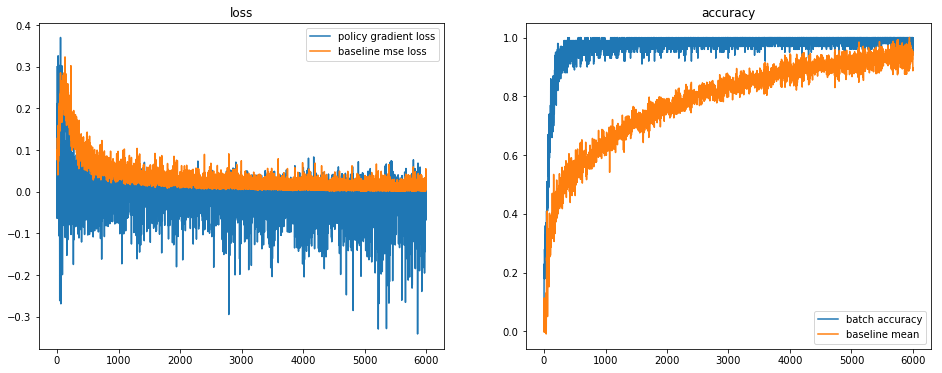

In [9]:
npstats = np.array(stats)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
#plt.plot(npstats[:, 0])
plt.plot(npstats[:, 1])
plt.plot(npstats[:, 2])
#plt.legend(['total loss', 'policy gradient loss', 'baseline mse loss'])
plt.legend(['policy gradient loss', 'baseline mse loss'])
plt.title('loss')

plt.subplot(1, 2, 2)
plt.plot(npstats[:, 3])
plt.plot(npstats[:, 4])
plt.legend(['batch accuracy', 'baseline mean'])
#plt.legend(['batch accuracy'])
plt.title('accuracy')

In [10]:
a = np.zeros((x_test.shape[0], 1))
y_pred, baselines = model.predict([x_test, a])
y_pred = np.argmax(y_pred, axis=1)
print(np.mean(y_pred == y_test))

0.9846
